In [53]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp
from more_itertools import distinct_permutations

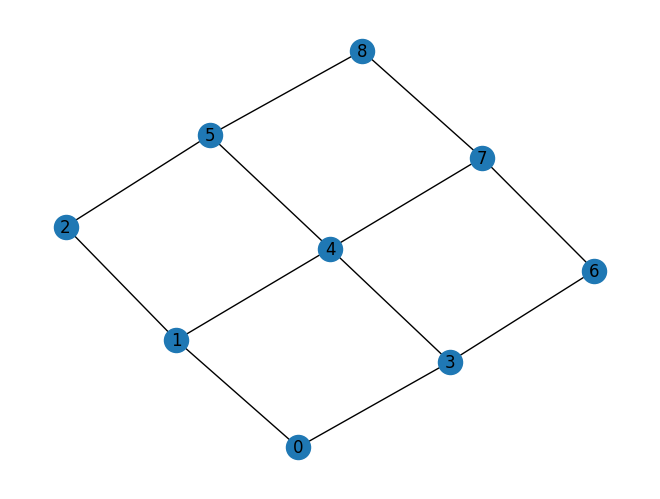

In [2]:
# Make square graph
l = 3
w = 3
n_qubits = l*w

G = nx.grid_graph((l,w))
G = nx.relabel_nodes(G, {e:i for i,e in enumerate(G.nodes)})

nx.draw(G, with_labels=True)

In [42]:
# Make XYZ Hamiltonian:
j1 = 1
j2 = 1
j3 = 1
h = 0.2

H = SparsePauliOp.from_sparse_list([('Z', [q], h) for q in G.nodes], num_qubits=len(G))
H += SparsePauliOp.from_sparse_list([('XX', e, j1) for e in G.edges], num_qubits=len(G))
H += SparsePauliOp.from_sparse_list([('YY', e, j2) for e in G.edges], num_qubits=len(G))
H += SparsePauliOp.from_sparse_list([('ZZ', e, j3) for e in G.edges], num_qubits=len(G))

In [43]:
H_mat = H.to_matrix(sparse=True)
true_gse, true_gs = sp.sparse.linalg.eigsh(H_mat, which='SA', k=1)
true_gse = true_gse[0]

In [84]:
checkerboard_excitations = [l*r + i for r in range(w) for i in range(l) if i%2==r%2]
v0 = np.zeros(2**n_qubits, dtype=complex)
v0[sum([2**q for q in checkerboard_excitations])] = 1

In [133]:
# Get the norm and spectral gap within the symmetry sector we are studying (model conserves Hamming weight)
def elem(dim, i):
    vec = np.zeros(dim)
    vec[i] = 1.0
    return vec

n_p = len(checkerboard_excitations)

symm_sec_vecs = np.array([elem(2**n_qubits, int(''.join(v), 2)) for v in distinct_permutations('0'*(n_qubits - n_p) + '1'*n_p)]).T

H_norm = np.linalg.norm(symm_sec_vecs.T @ H_mat @ symm_sec_vecs, ord=2)
H_norm_full = sp.sparse.linalg.norm(H_mat, ord=2)
assert(abs(H_norm-H_norm_full) < 1e-13) # Check that the norm in the symmetry sector we're looking at is equal to the full norm

dt = np.pi/H_norm
print('dt =',dt)

Delta = np.diff(sp.sparse.linalg.eigsh(symm_sec_vecs.T @ H_mat @ symm_sec_vecs, which='SA', k=2)[0:2][0])[0]
print('spectral gap =',Delta,'\n')

dt = 0.16364755331026698
spectral gap = 3.962683624557995 



In [87]:
d = 35 # Krylov dimension

In [39]:
# Construct Krylov vectors
v = [v0]
for i in range(d-1):
    ui = sp.sparse.linalg.expm_multiply(-1j*H_mat*dt, v[i])
    ui = ui/np.linalg.norm(ui)
    v.append(ui)

v = np.array(v).T

# Construct Krylov matrices
H_kry = np.conj(v).T @ H_mat @ v
S_kry = np.conj(v).T @ v

In [40]:
noise_rates = [10**(-x) for x in range(2,9)]
threshold_rescale = 0.1
reps = 10000

In [41]:
results = []
s_pert_norms = []
h_pert_norms = []

for r in noise_rates:
    results_by_rate = []
    s_pert_norms_by_rate = []
    h_pert_norms_by_rate = []

    for _ in range(reps):

        # Add Gaussian noise at rate r
        S_pert = np.exp(1j*np.random.uniform(0,2*np.pi)) * np.random.normal(scale=r, size=(d,d))
        S_pert = (S_pert+S_pert.T.conj())/2
        S_noisy = S_kry + S_pert

        H_pert = H_norm * np.exp(1j*np.random.uniform(0,2*np.pi)) * np.random.normal(scale=r, size=(d,d))
        H_pert = (H_pert+H_pert.T.conj())/2
        H_noisy = H_kry + H_pert

        s_pert_norms_by_rate.append(np.linalg.norm(S_pert, ord=2))
        h_pert_norms_by_rate.append(np.linalg.norm(H_pert, ord=2))

        approx_gs_energies = []

        # Look at all subspace dimensions up to d
        for _d in range(1,d+1):

            # Regularize by projecting onto good eigenspaces of S_kry
            s_vals, s_vecs = sp.linalg.eigh(S_noisy[:_d,:_d])
            s_vecs = s_vecs.T
            reg_transform = [vec for val, vec in zip(s_vals, s_vecs) if val > _d * threshold_rescale * r]
            if reg_transform is []:
                raise AssertionError('WHOLE SUBSPACE ILL-CONDITIONED')
            reg_transform = np.array(reg_transform).T
            H_reg = reg_transform.T.conj() @ H_noisy[:_d,:_d] @ reg_transform
            S_reg = reg_transform.T.conj() @ S_noisy[:_d,:_d] @ reg_transform

            # Solve generalized eigenvalue problem
            vals, vecs = sp.linalg.eigh(H_reg, S_reg)

            approx_gs_energies.append(min(vals))

        results_by_rate.append(approx_gs_energies)

    results.append(results_by_rate)
    s_pert_norms.append(s_pert_norms_by_rate)
    h_pert_norms.append(h_pert_norms_by_rate)

results = np.array(results)
s_pert_norms = np.array(s_pert_norms)
h_pert_norms = np.array(h_pert_norms)

KeyboardInterrupt: 

In [45]:
# np.save('results', results)
# np.save('s_pert_norms', s_pert_norms)
# np.save('h_pert_norms', h_pert_norms)

# LOAD DATA FOR PLOTS IN PAPER

results = np.load('results.npy')
s_pert_norms = np.load('s_pert_norms.npy')
h_pert_norms = np.load('h_pert_norms.npy')

In [46]:
mean_results = {r:np.mean(v,axis=0) for r,v in zip(noise_rates,results)}
# mean of middle x percent of data
# mean_results = {r:np.mean(np.sort(v, axis=0)[int(0.1*reps):int(0.9*reps)],axis=0) for r,v in results.items()}
median_results = {r:np.median(v,axis=0) for r,v in zip(noise_rates,results)}

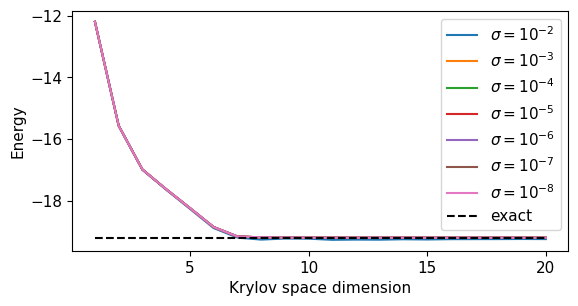

In [47]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

for r in noise_rates:
    plt.plot(range(1,21), median_results[r][:20], label=r'$\sigma=10^{{{}}}$'.format(int(np.log10(r))))

plt.plot(range(1,21), [true_gse for _ in range(1,21)], label='exact', color='k', linestyle='dashed')

plt.xticks(list(range(5,21,5)))
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.legend()

plt.gca().set_aspect(1.3)
plt.show()
# plt.savefig('convergence_plot.pdf', bbox_inches='tight')

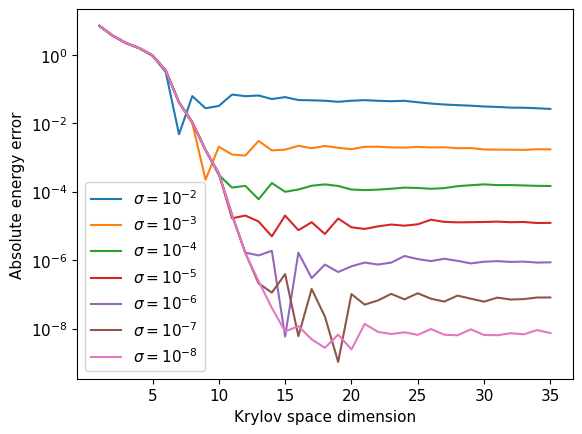

In [48]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

for i,r in enumerate(noise_rates):
    plt.plot(range(1,d+1), np.abs(median_results[r]-true_gse), label=r'$\sigma=10^{{{}}}$'.format(int(np.log10(r))))
plt.yscale('log')
plt.xticks(list(range(5,d+1,5)))
plt.xlabel('Krylov space dimension')
plt.ylabel('Absolute energy error')
plt.legend()

plt.show()
# plt.savefig('convergence_plot_log.pdf', bbox_inches='tight')

In [13]:
def upper_bound(H_norm, overlap, d, delta, delta_prime, Delta_prime, chi, zeta):
    term0 = delta_prime if delta_prime > Delta_prime else 0
    term1 = (1/overlap)*(1+6*H_norm/(delta_prime-delta))*chi
    term2 = (6*H_norm/overlap)*zeta
    term3 = (6*H_norm/overlap)*8*(1+0.5*np.pi*delta/H_norm)**(-2*d)
    out = term0+term1+term2+term3
    return out

In [14]:
mean_s_pert = {r:np.mean(v) for r,v in zip(noise_rates,s_pert_norms)}
mean_h_pert = {r:np.mean(v) for r,v in zip(noise_rates,h_pert_norms)}

chis = {r:mean_h_pert[r] + H_norm * mean_s_pert[r] for r in noise_rates}
zetas = {r:2 * d * (d * threshold_rescale * r + mean_s_pert[r]) for r in noise_rates}

In [127]:
overlap = np.abs(true_gs.T[0] @ v0)**2
print('overlap =',overlap,'\n')
overlap_primes = {r:overlap - 2 * d * threshold_rescale * r - 2 * mean_s_pert[r] for r in noise_rates}
print('overlap_primes =',overlap_primes,'\n')
Delta_primes = {r:Delta - chis[r]/overlap_primes[r] for r in noise_rates}
print('Delta_primes =',Delta_primes,'\n')

bounds = {}
for r in noise_rates:
    def upper_bound_fn(x):
        return upper_bound(H_norm, overlap_primes[r], d, x[0], x[1], Delta_primes[r], chis[r], zetas[r])
    
    if Delta_primes[r] > 0:
        x0 = (Delta_primes[r]/2, Delta_primes[r])
    else:
        x0 = (Delta/2,Delta)
    
    
    # Minimize over values of delta and delta_prime:
    min_bound = sp.optimize.minimize(
        upper_bound_fn,
        method='COBYLA',
        x0=x0,
        constraints=(
            {'type': 'ineq', 'fun': lambda x:  x[1]-x[0]-chis[r]/overlap_primes[r]},
            {'type': 'ineq', 'fun': lambda x:  x[0]},
            {'type': 'ineq', 'fun': lambda x:  x[1]},
            {'type': 'ineq', 'fun': lambda x:  (Delta_primes[r]-0.01 if Delta_primes[r]>0.01 else Delta) - x[1]}
            )
        )
    
    if min_bound.fun < upper_bound_fn(x0):
        bounds[r] = min_bound.fun
    else:
        print('Minimization failed at noise rate', r, '-> bound', min_bound.fun, 'replaced with default (initial) point')
        bounds[r] = upper_bound_fn(x0)

bounds

overlap = 0.27533219074476195 

overlap_primes = {0.01: 0.047706527625256956, 0.001: 0.25255962872822085, 0.0001: 0.2730547939292945, 1e-05: 0.2751044076063486, 1e-06: 0.2753094349580247, 1e-07: 0.2753299141567956, 1e-08: 0.27533196299743473} 

Delta_primes = {0.01: -59.50575481394758, 0.001: 2.7637570180096738, 0.0001: 3.8517577387306003, 1e-05: 3.95167104202721, 1e-06: 3.9615844052674083, 1e-07: 3.9625737219380235, 1e-08: 3.962672629142157} 

Minimization failed at noise rate 0.01 -> bound 1.3127017319634332e+195 replaced with default (initial) point


{0.01: 22993.126805907337,
 0.001: 456.92574901205194,
 0.0001: 40.038965167367465,
 1e-05: 4.083884405422805,
 1e-06: 0.42774989826099535,
 1e-07: 0.04620733101516959,
 1e-08: 0.005276385731277279}

In [128]:
# lower bound value
{r:(mean_h_pert[r] + (1+np.sqrt(2)) * H_norm * mean_s_pert[r])/(d * threshold_rescale * r) for r in noise_rates}

{0.01: 147.64445277011018,
 0.001: 147.6873855181462,
 0.0001: 147.7179792400668,
 1e-05: 147.7555624125788,
 1e-06: 147.57231875751606,
 1e-07: 147.60270570497704,
 1e-08: 147.67822840144805}

In [129]:
# break up data into positive and negative errors, collecting all of the points from the last ten dimensions
positive_errors = {}
negative_errors = {}
for r,v in zip(noise_rates,results):
    positive_errors[r] = []
    negative_errors[r] = []
    for _d in range(d-10, d):
        for energy in v.T[_d]:
            error = energy-true_gse
            if error >= 0:
                positive_errors[r].append(error)
            else:
                negative_errors[r].append(error)

print([len(v) for v in positive_errors.values()])
print([len(v) for v in negative_errors.values()])

[11090, 22186, 26656, 29306, 34886, 37064, 37298]
[88910, 77814, 73344, 70694, 65114, 62936, 62702]


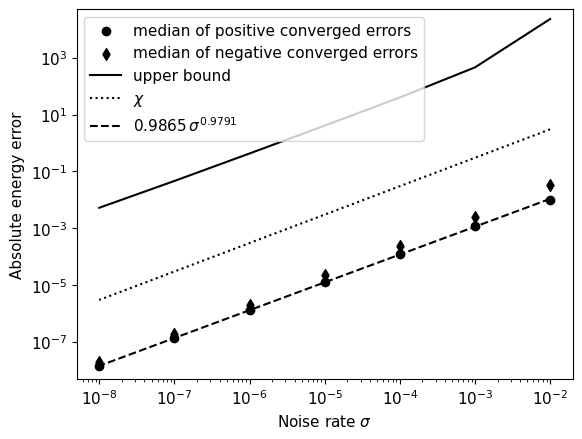

In [130]:
plt.scatter(noise_rates, [np.median(positive_errors[r]) for r in noise_rates], label='median of positive converged errors', color='k')
plt.scatter(noise_rates, [-np.median(negative_errors[r]) for r in noise_rates], label='median of negative converged errors', color='k', marker='d')

plt.plot(noise_rates, bounds.values(), label='upper bound', color='k')
plt.plot(noise_rates, chis.values(), label=r'$\chi$', color='k', linestyle='dotted')

def f(x, m, b):
    return m*x+b

popt, pcov = sp.optimize.curve_fit(f, np.log(np.array(noise_rates)), np.log(np.array([np.median(positive_errors[r]) for r in noise_rates])))

plt.plot(noise_rates, [np.exp(popt[1])*(r**popt[0]) for r in noise_rates], label=r'${}\,\sigma^{{{}}}$'.format(np.round(np.exp(popt[1]),4),np.round(popt[0],4)), color='k', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Noise rate $\sigma$')
plt.ylabel('Absolute energy error')
plt.ylim((5e-9,5e4))
plt.legend()

plt.savefig('bound_example.pdf', bbox_inches='tight')